In [36]:
import torch
from torch.autograd import Variable
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse.linalg import svds, eigs
import utils,models,time,sys
import os
import itertools
import shutil
import tensorflow as tf
from tensorflow.contrib.layers import apply_regularization, l2_regularizer
import matplotlib.pyplot as plt
from vaecf import MultiVAE
import eval_utils

In [2]:
class MatrixFactorization(torch.nn.Module):

    def __init__(self,
                 n_users,
                 n_items,
                 n_factors=40,
                 dropout_p=0,
                 sparse=False):
        """
        Parameters
        ----------
        n_users : int
            Number of users
        n_items : int
            Number of items
        n_factors : int
            Number of latent factors (or embeddings or whatever you want to
            call it).
        dropout_p : float
            p in nn.Dropout module. Probability of dropout.
        sparse : bool
            Whether or not to treat embeddings as sparse. NOTE: cannot use
            weight decay on the optimizer if sparse=True. Also, can only use
            Adagrad.
        """
        super(MatrixFactorization, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.user_biases = torch.nn.Embedding(n_users, 1, sparse=sparse)
        self.item_biases = torch.nn.Embedding(n_items, 1, sparse=sparse)
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors, sparse=sparse)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors, sparse=sparse)
        
        self.dropout_p = dropout_p
        self.dropout = torch.nn.Dropout(p=self.dropout_p)

        self.sparse = sparse
        
    def forward(self, users, items):
        """
        Forward pass through the model. For a single user and item, this
        looks like:
        user_bias + item_bias + user_embeddings.dot(item_embeddings)
        Parameters
        ----------
        users : np.ndarray
            Array of user indices
        items : np.ndarray
            Array of item indices
        Returns
        -------
        preds : np.ndarray
            Predicted ratings.
        """
        ues = self.user_embeddings(users)
        uis = self.item_embeddings(items)

        #preds = self.user_biases(users)
        #preds += self.item_biases(items)
        preds2 = (self.dropout(ues) * self.dropout(uis)).sum(1)
        return preds2
    
    def __call__(self, *args):
        return self.forward(*args)

    def predict(self, users, items):
        return self.forward(users, items)

In [2]:
dataset_name='msd-exp-40-160'
train_dir = "../train/"
print 'reading training and testing file.'

n_users, n_items, train_data = utils.load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)

reading training and testing file.


In [19]:
train_data[0].nonzero()[1].tolist()

[148, 299, 476, 688, 1617, 1664]

In [29]:
hit = 100
a = [1,10,9]
a.pop
print a

ValueError: list.remove(x): x not in list

In [47]:
def make_training_tuple(train_data, users, n_items, neg_num=10):
    u_list = []
    i_list = []
    r_list = []
    for u in users:
        neg_sample = np.random.choice(n_items, 100)
        pos_items = train_data[u].nonzero()[1].tolist()
        for pos_item in pos_items:
            neg_sample = np.random.choice(n_items, 10).tolist()
            if pos_item in neg_sample:
                neg_sample.remove(pos_item)
            u_list += [u]*(len(neg_sample)+1)
            i_list.append(pos_item)
            r_list.append(1.0)
            i_list += neg_sample
            r_list += [0.0] * len(neg_sample)
    return u_list, i_list, r_list

In [53]:
model = MatrixFactorization(n_users, n_items, n_factors=16)
loss_fn = torch.nn.MSELoss(size_average=False) 
#loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=5e-3)

num_epochs = 100
N = train_data.shape[0]
idxlist = range(N)
batch_size = 256
for epoch in range(num_epochs):
    np.random.shuffle(idxlist)
    total_loss = torch.Tensor([0])
    for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            u,i,r = make_training_tuple(train_data, idxlist[st_idx:end_idx], n_items, 20)
            #X = train_data[idxlist[st_idx:end_idx]].tocoo()
            users = Variable(torch.LongTensor(u))
            items = Variable(torch.LongTensor(i))
            ratings = Variable(torch.FloatTensor(r))
            prediction = model(users, items)
            optimizer.zero_grad()
            loss = loss_fn(prediction, ratings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    topk = 10
    limit = 10000
    evaluation = eval_utils.mf_evaluation(model, testRatings, testNegatives, topk)
    (hits, ndcgs) = evaluation.evaluate(1, limit_size=limit)
    hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print('epoch = %d, test_size = %d, HR = %.4f, NDCG = %.4f, loss = %.4f'  % (epoch, len(hits), hr, ndcg, total_loss))

epoch = 0, test_size = 10000, HR = 0.0962, NDCG = 0.0430, loss = 15507809.0000
epoch = 1, test_size = 10000, HR = 0.0952, NDCG = 0.0426, loss = 10190454.0000
epoch = 2, test_size = 10000, HR = 0.0954, NDCG = 0.0426, loss = 6650565.5000
epoch = 3, test_size = 10000, HR = 0.0957, NDCG = 0.0430, loss = 4336228.5000
epoch = 4, test_size = 10000, HR = 0.0945, NDCG = 0.0426, loss = 2857521.2500
epoch = 5, test_size = 10000, HR = 0.0945, NDCG = 0.0428, loss = 1900734.3750
epoch = 6, test_size = 10000, HR = 0.0926, NDCG = 0.0421, loss = 1268879.1250
epoch = 7, test_size = 10000, HR = 0.0931, NDCG = 0.0423, loss = 859844.5000
epoch = 8, test_size = 10000, HR = 0.0936, NDCG = 0.0425, loss = 590780.3750
epoch = 9, test_size = 10000, HR = 0.0931, NDCG = 0.0425, loss = 417914.8125
epoch = 10, test_size = 10000, HR = 0.0963, NDCG = 0.0434, loss = 303211.9688
epoch = 11, test_size = 10000, HR = 0.0986, NDCG = 0.0445, loss = 231273.1875
epoch = 12, test_size = 10000, HR = 0.0985, NDCG = 0.0446, loss =

KeyboardInterrupt: 

In [56]:
A = sparse.csc_matrix([[1, 0, 0], [5, 0, 2], [0, -1, 0], [0, 0, 3]], dtype=float)
u, s, vt = svds(A, k=2)

In [86]:
np.matmul(u[1],(s*vt.T).T)

array([ 5.00000000e+00, -6.43251766e-18,  2.00000000e+00])

In [105]:
u, s, vt = svds(train_data, k=64)

In [106]:
pred = np.matmul(u,(s*vt.T).T)

In [108]:
evaluator = eval_utils.vaecf_evaluation(pred, testRatings, testNegatives, topk)
(hits, ndcgs) = evaluator.evaluate(1, limit_size=100000)
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('test_size = %d, HR = %.4f, NDCG = %.4f'  % ( len(hits), hr, ndcg))

test_size = 44967, HR = 0.3433, NDCG = 0.1959


In [6]:
def nonzeros(m, row):
    """ returns the non zeroes of a row in csr_matrix """
    for index in range(m.indptr[row], m.indptr[row+1]):
        yield m.indices[index], m.data[index]

def alternating_least_squares(Cui, factors, regularization, iterations=20):
    users, items = Cui.shape

    X = np.random.rand(users, factors) * 0.01
    Y = np.random.rand(items, factors) * 0.01

    Ciu = Cui.T.tocsr()
    for iteration in range(iterations):
        print iteration
        least_squares(Cui, X, Y, regularization)
        least_squares(Ciu, Y, X, regularization)

    return X, Y

def least_squares(Cui, X, Y, regularization):
    users, factors = X.shape
    YtY = Y.T.dot(Y)

    for u in range(users):
        # accumulate YtCuY + regularization * I in A
        A = YtY + regularization * np.eye(factors)

        # accumulate YtCuPu in b
        b = np.zeros(factors)

        for i, confidence in nonzeros(Cui, u):
            factor = Y[i]
            A += (confidence - 1) * np.outer(factor, factor)
            b += confidence * factor

        # Xu = (YtCuY + regularization * I)^-1 (YtCuPu)
        X[u] = np.linalg.solve(A, b)

In [12]:
X, Y = alternating_least_squares(train_data, 32, 0.1, iterations=30)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [13]:
pred = np.dot(X,Y.T)

In [14]:
topk=10
evaluator = eval_utils.vaecf_evaluation(pred, testRatings, testNegatives, topk)
(hits, ndcgs) = evaluator.evaluate(1, limit_size=100000)
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('ALS, test_size = %d, HR = %.4f, NDCG = %.4f'  % ( len(hits), hr, ndcg))

ALS, test_size = 100000, HR = 0.4807, NDCG = 0.3022


In [3]:
def test_item_popularity(train_data, testRatings, testNegatives, topk=10, limit=100000):
    item_pop = {}
    for i in range(n_items):
        item_pop[i] = train_data[:,i].count_nonzero()
    item_pop_evaluation = eval_utils.item_popularity_evaluation(item_pop, testRatings, testNegatives, topk)
    (hits, ndcgs) = item_pop_evaluation.evaluate(num_thread=1, limit_size=limit)
    item_pop_hr, item_pop_ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print 'Item Popularity, testSize=%d, HitRate=%.4f, NDCG=%.4f' % (len(hits), item_pop_hr, item_pop_ndcg)
    return item_pop_hr, item_pop_ndcg

In [4]:
hr1, ndcg1 = test_item_popularity(train_data, testRatings, testNegatives)

Item Popularity, testSize=100000, HitRate=0.3690, NDCG=0.2194


In [15]:
def test_mf_als(train_data, testRatings, testNegatives, n_epochs = 20, factors=64, topk=10, limit=10000):
    X, Y = alternating_least_squares(train_data, factors, regularization=0.1, iterations=n_epochs)
    pred = np.dot(X,Y.T)
    evaluator = eval_utils.vaecf_evaluation(pred, testRatings, testNegatives, topk)
    (hits, ndcgs) = evaluator.evaluate(1, limit_size=limit)
    hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print('MF_ALS, test_size = %d, HR = %.4f, NDCG = %.4f'  % ( len(hits), hr, ndcg))
    return hr, ndcg

In [17]:
train_dir = "../train/"
dataset_config = {'msd-little':(40,160), 'msd-user-sparse':(10,100),'msd-item-sparse':(40,40)}
k='msd-little'
user_threashold = dataset_config[k][0]
song_threashold = dataset_config[k][1]
dataset_name=k
print 'loading',dataset_name

n_users, n_items, train_data = utils.load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
vad_data_tr = utils.load_test_data(os.path.join(train_dir, '%s.train.rating' % dataset_name),n_users, n_items)
vad_data_te = utils.load_test_data(os.path.join(train_dir, '%s.test.rating' % dataset_name),n_users, n_items)

topk = 10
limit = 10000

hr4, ndcg4 = test_mf_als(train_data, testRatings, testNegatives, n_epochs = 30, factors=128, topk=topk, limit=limit)

loading msd-little
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
MF_ALS, test_size = 100000, HR = 0.4751, NDCG = 0.3088


In [18]:
train_dir = "../train/"
dataset_config = {'msd-little':(40,160), 'msd-user-sparse':(10,100),'msd-item-sparse':(40,40)}
k='msd-user-sparse'
user_threashold = dataset_config[k][0]
song_threashold = dataset_config[k][1]
dataset_name=k
print 'loading',dataset_name

n_users, n_items, train_data = utils.load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
vad_data_tr = utils.load_test_data(os.path.join(train_dir, '%s.train.rating' % dataset_name),n_users, n_items)
vad_data_te = utils.load_test_data(os.path.join(train_dir, '%s.test.rating' % dataset_name),n_users, n_items)

topk = 10
limit = 10000

hr4, ndcg4 = test_mf_als(train_data, testRatings, testNegatives, n_epochs = 20, factors=64, topk=topk, limit=limit)

loading msd-user-sparse
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
MF_ALS, test_size = 100000, HR = 0.4765, NDCG = 0.2977


In [19]:
def test_usercf(dataset_name, testRatings, testNegatives, topk=10, limit=100000, alpha=0.5, knn=500):
    u2s = dict()
    s2u = dict()

    train_file = '../train/%s.train.rating' % dataset_name
    print 'reading training file.'
    with open(train_file, 'r') as f:
        for line in f:
            if line != None and line != "":
                arr = line.split("\t")
                user, song = int(arr[0]), int(arr[1])
                if user not in u2s:
                    u2s[user] = set()
                u2s[user].add(song)
                if song not in s2u:
                    s2u[song] = set()
                s2u[song].add(user)
    
    model = models.UserCF(u2s, s2u, sim_method='cos', alpha=alpha, knn=knn)
    evaluator = eval_utils.usercf_evaluation(model, u2s, testRatings, testNegatives, K=topk)
    (hits, ndcgs) = evaluator.evaluate(num_thread=1, limit_size=limit)
    usercf_hr, usercf_ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print('UserCF, knn = %d, HR = %.4f, NDCG = %.4f'  % (knn, usercf_hr, usercf_ndcg))
    return usercf_hr, usercf_ndcg

In [43]:
train_dir = "../train/"
dataset_config = {'msd-little':(40,160), 'msd-user-sparse':(10,100),'msd-item-sparse':(40,40)}
k='msd-little'
user_threashold = dataset_config[k][0]
song_threashold = dataset_config[k][1]
dataset_name=k
print 'loading',dataset_name

topk = 10
limit = 10000

params = []
p_hrs = []
p_ndcg = []
dataset_name='msd-little'
testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
knn=500
for alpha in np.arange(0.1,1.1,0.1):
    usercf_hr, usercf_ndcg = test_usercf(dataset_name, testRatings, testNegatives, topk=10, limit=10000, alpha=alpha, knn=knn)
    params.append(alpha)
    p_hrs.append(usercf_hr)
    p_ndcg.append(usercf_ndcg)
    print('UserCF, alpha, knn = %d, alpha = %.2f, HR = %.4f, NDCG = %.4f'  % (knn, alpha, usercf_hr, usercf_ndcg))

loading msd-little
reading training file.
UserCF, knn = 500, HR = 0.6271, NDCG = 0.4373
UserCF, alpha, knn = 500, alpha = 0.10, HR = 0.6271, NDCG = 0.4373
reading training file.
UserCF, knn = 500, HR = 0.6315, NDCG = 0.4377
UserCF, alpha, knn = 500, alpha = 0.20, HR = 0.6315, NDCG = 0.4377
reading training file.
UserCF, knn = 500, HR = 0.6318, NDCG = 0.4342
UserCF, alpha, knn = 500, alpha = 0.30, HR = 0.6318, NDCG = 0.4342
reading training file.
UserCF, knn = 500, HR = 0.6305, NDCG = 0.4299
UserCF, alpha, knn = 500, alpha = 0.40, HR = 0.6305, NDCG = 0.4299
reading training file.
UserCF, knn = 500, HR = 0.6254, NDCG = 0.4238
UserCF, alpha, knn = 500, alpha = 0.50, HR = 0.6254, NDCG = 0.4238
reading training file.
UserCF, knn = 500, HR = 0.6211, NDCG = 0.4179
UserCF, alpha, knn = 500, alpha = 0.60, HR = 0.6211, NDCG = 0.4179
reading training file.
UserCF, knn = 500, HR = 0.6154, NDCG = 0.4119
UserCF, alpha, knn = 500, alpha = 0.70, HR = 0.6154, NDCG = 0.4119
reading training file.
UserCF

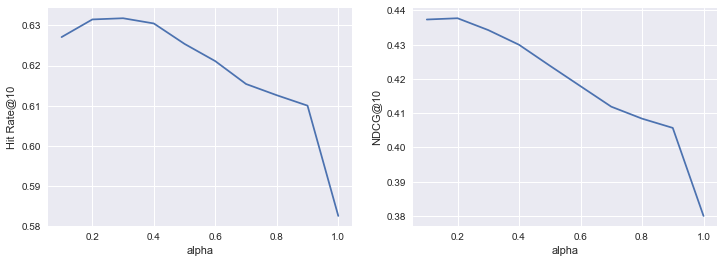

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
topk=10
ax1.plot(params, p_hrs)
ax1.set_ylabel("Hit Rate@%d" % topk)
ax1.set_xlabel("alpha")

ax2.plot(params, p_ndcg)
ax2.set_ylabel("NDCG@%d" % topk)
ax2.set_xlabel("alpha")

pass

In [23]:
train_dir = "../train/"
dataset_config = {'msd-little':(40,160), 'msd-user-sparse':(10,100),'msd-item-sparse':(40,40)}
k='msd-user-sparse'
user_threashold = dataset_config[k][0]
song_threashold = dataset_config[k][1]
dataset_name=k
print 'loading',dataset_name

n_users, n_items, train_data = utils.load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
vad_data_tr = utils.load_test_data(os.path.join(train_dir, '%s.train.rating' % dataset_name),n_users, n_items)
vad_data_te = utils.load_test_data(os.path.join(train_dir, '%s.test.rating' % dataset_name),n_users, n_items)

topk = 10
limit = 10000

hr21, ndcg21 = test_usercf(dataset_name, testRatings, testNegatives, topk, limit, knn=500)

loading msd-user-sparse
reading training file.
UserCF, knn = 500, HR = 0.6507, NDCG = 0.4672


In [24]:
dataset_config = {'msd-little':(40,160), 'msd-user-sparse':(10,100),'msd-item-sparse':(40,40)}
for k in ['msd-item-sparse','msd-user-sparse','msd-little']:
    train_dir = "../train/"
    user_threashold = dataset_config[k][0]
    song_threashold = dataset_config[k][1]
    dataset_name=k
    print 'loading',dataset_name

    n_users, n_items, train_data = utils.load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
    testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
    testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
    vad_data_tr = utils.load_test_data(os.path.join(train_dir, '%s.train.rating' % dataset_name),n_users, n_items)
    vad_data_te = utils.load_test_data(os.path.join(train_dir, '%s.test.rating' % dataset_name),n_users, n_items)
    print dataset_name,n_users, n_items, train_data.count_nonzero()


loading msd-item-sparse
msd-item-sparse 20574 13295 480775
loading msd-user-sparse
msd-user-sparse 103181 4793 921795
loading msd-little
msd-little 20574 2557 257874


In [32]:
def test_vaecf(n_users, n_items, train_data, vad_data_tr, vad_data_te, testRatings, testNegatives, n_epochs = 20, lr=1e-4, topk=10, limit=10000, batch_size=256, hidden_dims=[300], beta=0.2, epoch_size=1000000, eval_epoch=1, total_anneal_steps=2000):
    
    N = min(train_data.shape[0],vad_data_te.shape[0])
    idxlist = range(N)

    # training batch size
    batch_size = batch_size
    batches_per_epoch = int(np.ceil(float(N) / batch_size))

    N_vad = min(vad_data_tr.shape[0],vad_data_te.shape[0])
    idxlist_vad = range(N_vad)

    # validation batch size (since the entire validation set might not fit into GPU memory)
    batch_size_vad = 300

    # the total number of gradient updates for annealing
    total_anneal_steps = 2000
    # largest annealing parameter
    anneal_cap = beta

    # p_dims = [200, 600, n_items]
    p_dims = hidden_dims+[n_items]

    tf.reset_default_graph()
    vae = MultiVAE(p_dims, lam=0.000, lr=lr, random_seed=98765)

    saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

    ndcg_var = tf.Variable(0.0)
    ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
    ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
    ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
    merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

    pro_dir = train_dir
    arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))
    log_dir = pro_dir+'/VAE_anneal{}K_cap{:1.1E}/{}'.format(
        total_anneal_steps/1000, anneal_cap, arch_str)

    if os.path.exists(log_dir):
        shutil.rmtree(log_dir)

    #print("log directory: %s" % log_dir)
    summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

    chkpt_dir = pro_dir+'/VAE_anneal{}K_cap{:1.1E}/{}'.format(
        total_anneal_steps/1000, anneal_cap, arch_str)

    if not os.path.isdir(chkpt_dir):
        os.makedirs(chkpt_dir) 

    #print("chkpt directory: %s" % chkpt_dir)
    
    ndcgs_vad = []
    hrs_vad = []
    best_ndcg = 0
    best_hr = 0
    pred_result = []
    epoch_size = epoch_size

    with tf.Session() as sess:

        init = tf.global_variables_initializer()
        sess.run(init)
        best_ndcg = -np.inf
        update_count = 0.0

        for epoch in range(n_epochs):
            np.random.shuffle(idxlist)
            # train for one epoch
            total_loss = 0.0
            for bnum, st_idx in enumerate(range(0, epoch_size, batch_size)):
                end_idx = min(st_idx + batch_size, N)
                X = train_data[idxlist[st_idx:end_idx]]

                if sparse.isspmatrix(X):
                    X = X.toarray()
                X = X.astype('float32')           

                if total_anneal_steps > 0:
                    anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
                else:
                    anneal = anneal_cap

                feed_dict = {vae.input_ph: X, 
                             vae.keep_prob_ph: 0.5, 
                             vae.anneal_ph: anneal,
                             vae.is_training_ph: 1}        
                sess.run(train_op_var, feed_dict=feed_dict)

                if bnum % 100 == 0:
                    summary_train = sess.run(merged_var, feed_dict=feed_dict)
                    summary_writer.add_summary(summary_train, 
                                               global_step=epoch * batches_per_epoch + bnum) 

                update_count += 1

            if epoch % eval_epoch ==0:
                X = vad_data_tr
                if sparse.isspmatrix(X):
                    X = X.toarray()
                X = X.astype('float32')

                pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
                pred_val[X.nonzero()] = -np.inf
                evaluation = eval_utils.vaecf_evaluation(pred_val, testRatings, testNegatives, topk)
                (hits, ndcgs) = evaluation.evaluate(1, limit_size=limit)
                hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
                print('VAECF: epoch = %d, beta = %.2f, update_count = %d, test_size = %d, HR = %.4f, NDCG = %.4f'  % (epoch, beta, update_count, len(hits), hr, ndcg))

                ndcgs_vad.append(ndcg)
                hrs_vad.append(hr)

                # update the best model (if necessary)
                if ndcg > best_ndcg:
                    saver.save(sess, '{}/model'.format(chkpt_dir))
                    best_ndcg = ndcg
                    best_hr = hr
                
        print('VAECF: test_size = %d, HR = %.4f, NDCG = %.4f'  % (len(hits), best_hr, best_ndcg))
    return best_hr, best_ndcg, hrs_vad, ndcgs_vad

In [30]:
# test of beta
train_dir = "../train/"
k='msd-little'
user_threashold = dataset_config[k][0]
song_threashold = dataset_config[k][1]
dataset_name=k
print 'loading',dataset_name

n_users, n_items, train_data = utils.load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
testRatings =  utils.load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = utils.load_negative_file("../train/%s.test.negative" % dataset_name)
vad_data_tr = utils.load_test_data(os.path.join(train_dir, '%s.train.rating' % dataset_name),n_users, n_items)
vad_data_te = utils.load_test_data(os.path.join(train_dir, '%s.test.rating' % dataset_name),n_users, n_items)

topk = 10
limit = 10000

vae_hrs = {}
vae_ndcgs = {}
beta_range = [0, 0.1, 0.2, 0.5, 1.0]
for beta in beta_range:
    best_hr, best_ndcg, hrs, ndcgs = test_vaecf(n_users, n_items, train_data, vad_data_tr, vad_data_te, testRatings, testNegatives, n_epochs=100, lr=5e-4, batch_size=256, hidden_dims=[1000], epoch_size=30000, beta=beta, eval_epoch=2)
    vae_hrs[beta] = hrs
    vae_ndcgs[beta] = ndcgs
    print beta, hrs, ndcgs


loading msd-little
INFO:tensorflow:Scale of 0 disables regularizer.
VAECF: epoch = 0, beta = 0.00, update_count = 118, test_size = 10000, HR = 0.3626, NDCG = 0.2162
VAECF: epoch = 2, beta = 0.00, update_count = 354, test_size = 10000, HR = 0.3729, NDCG = 0.2272
VAECF: epoch = 4, beta = 0.00, update_count = 590, test_size = 10000, HR = 0.4640, NDCG = 0.2989
VAECF: epoch = 6, beta = 0.00, update_count = 826, test_size = 10000, HR = 0.5608, NDCG = 0.3738
VAECF: epoch = 8, beta = 0.00, update_count = 1062, test_size = 10000, HR = 0.6168, NDCG = 0.4164
VAECF: epoch = 10, beta = 0.00, update_count = 1298, test_size = 10000, HR = 0.6434, NDCG = 0.4387
VAECF: epoch = 12, beta = 0.00, update_count = 1534, test_size = 10000, HR = 0.6589, NDCG = 0.4515
VAECF: epoch = 14, beta = 0.00, update_count = 1770, test_size = 10000, HR = 0.6661, NDCG = 0.4575
VAECF: epoch = 16, beta = 0.00, update_count = 2006, test_size = 10000, HR = 0.6689, NDCG = 0.4576
VAECF: epoch = 18, beta = 0.00, update_count = 224

VAECF: epoch = 34, beta = 0.10, update_count = 4130, test_size = 10000, HR = 0.6699, NDCG = 0.4630
VAECF: epoch = 36, beta = 0.10, update_count = 4366, test_size = 10000, HR = 0.6722, NDCG = 0.4627
VAECF: epoch = 38, beta = 0.10, update_count = 4602, test_size = 10000, HR = 0.6689, NDCG = 0.4598
VAECF: epoch = 40, beta = 0.10, update_count = 4838, test_size = 10000, HR = 0.6665, NDCG = 0.4589
VAECF: epoch = 42, beta = 0.10, update_count = 5074, test_size = 10000, HR = 0.6652, NDCG = 0.4577
VAECF: epoch = 44, beta = 0.10, update_count = 5310, test_size = 10000, HR = 0.6659, NDCG = 0.4580
VAECF: epoch = 46, beta = 0.10, update_count = 5546, test_size = 10000, HR = 0.6635, NDCG = 0.4545
VAECF: epoch = 48, beta = 0.10, update_count = 5782, test_size = 10000, HR = 0.6656, NDCG = 0.4545
VAECF: epoch = 50, beta = 0.10, update_count = 6018, test_size = 10000, HR = 0.6632, NDCG = 0.4555
VAECF: epoch = 52, beta = 0.10, update_count = 6254, test_size = 10000, HR = 0.6621, NDCG = 0.4537
VAECF: epo

VAECF: epoch = 70, beta = 0.20, update_count = 8378, test_size = 10000, HR = 0.6685, NDCG = 0.4585
VAECF: epoch = 72, beta = 0.20, update_count = 8614, test_size = 10000, HR = 0.6682, NDCG = 0.4578
VAECF: epoch = 74, beta = 0.20, update_count = 8850, test_size = 10000, HR = 0.6669, NDCG = 0.4573
VAECF: epoch = 76, beta = 0.20, update_count = 9086, test_size = 10000, HR = 0.6658, NDCG = 0.4554
VAECF: epoch = 78, beta = 0.20, update_count = 9322, test_size = 10000, HR = 0.6660, NDCG = 0.4553
VAECF: epoch = 80, beta = 0.20, update_count = 9558, test_size = 10000, HR = 0.6644, NDCG = 0.4530
VAECF: epoch = 82, beta = 0.20, update_count = 9794, test_size = 10000, HR = 0.6643, NDCG = 0.4534
VAECF: epoch = 84, beta = 0.20, update_count = 10030, test_size = 10000, HR = 0.6647, NDCG = 0.4529
VAECF: epoch = 86, beta = 0.20, update_count = 10266, test_size = 10000, HR = 0.6625, NDCG = 0.4521
VAECF: epoch = 88, beta = 0.20, update_count = 10502, test_size = 10000, HR = 0.6621, NDCG = 0.4511
VAECF: 

VAECF: epoch = 0, beta = 1.00, update_count = 118, test_size = 10000, HR = 0.3626, NDCG = 0.2161
VAECF: epoch = 2, beta = 1.00, update_count = 354, test_size = 10000, HR = 0.3862, NDCG = 0.2358
VAECF: epoch = 4, beta = 1.00, update_count = 590, test_size = 10000, HR = 0.4786, NDCG = 0.3119
VAECF: epoch = 6, beta = 1.00, update_count = 826, test_size = 10000, HR = 0.5514, NDCG = 0.3671
VAECF: epoch = 8, beta = 1.00, update_count = 1062, test_size = 10000, HR = 0.5918, NDCG = 0.3997
VAECF: epoch = 10, beta = 1.00, update_count = 1298, test_size = 10000, HR = 0.6081, NDCG = 0.4120
VAECF: epoch = 12, beta = 1.00, update_count = 1534, test_size = 10000, HR = 0.6200, NDCG = 0.4228
VAECF: epoch = 14, beta = 1.00, update_count = 1770, test_size = 10000, HR = 0.6244, NDCG = 0.4263
VAECF: epoch = 16, beta = 1.00, update_count = 2006, test_size = 10000, HR = 0.6291, NDCG = 0.4280
VAECF: epoch = 18, beta = 1.00, update_count = 2242, test_size = 10000, HR = 0.6312, NDCG = 0.4287
VAECF: epoch = 20, 

In [33]:
beta=0.2
best_hr, best_ndcg, hrs, ndcgs = test_vaecf(n_users, n_items, train_data, vad_data_tr, vad_data_te, testRatings, testNegatives, n_epochs=100, lr=5e-4, batch_size=256, hidden_dims=[1000], epoch_size=30000, beta=beta, eval_epoch=2, total_anneal_steps=0)
vae_hrs[-1] = hrs
vae_ndcgs[-1] = ndcgs
print hrs, ndcgs


INFO:tensorflow:Scale of 0 disables regularizer.
VAECF: epoch = 0, beta = 0.20, update_count = 118, test_size = 10000, HR = 0.3643, NDCG = 0.2166
VAECF: epoch = 1, beta = 0.20, update_count = 236, test_size = 10000, HR = 0.3576, NDCG = 0.2148
VAECF: epoch = 2, beta = 0.20, update_count = 354, test_size = 10000, HR = 0.3830, NDCG = 0.2341
VAECF: epoch = 3, beta = 0.20, update_count = 472, test_size = 10000, HR = 0.4293, NDCG = 0.2710
VAECF: epoch = 4, beta = 0.20, update_count = 590, test_size = 10000, HR = 0.4720, NDCG = 0.3080
VAECF: epoch = 5, beta = 0.20, update_count = 708, test_size = 10000, HR = 0.5145, NDCG = 0.3410
VAECF: epoch = 6, beta = 0.20, update_count = 826, test_size = 10000, HR = 0.5545, NDCG = 0.3699
VAECF: epoch = 7, beta = 0.20, update_count = 944, test_size = 10000, HR = 0.5789, NDCG = 0.3897
VAECF: epoch = 8, beta = 0.20, update_count = 1062, test_size = 10000, HR = 0.5999, NDCG = 0.4074
VAECF: epoch = 9, beta = 0.20, update_count = 1180, test_size = 10000, HR = 0

VAECF: epoch = 83, beta = 0.20, update_count = 9912, test_size = 10000, HR = 0.6623, NDCG = 0.4490
VAECF: epoch = 84, beta = 0.20, update_count = 10030, test_size = 10000, HR = 0.6627, NDCG = 0.4511
VAECF: epoch = 85, beta = 0.20, update_count = 10148, test_size = 10000, HR = 0.6625, NDCG = 0.4501
VAECF: epoch = 86, beta = 0.20, update_count = 10266, test_size = 10000, HR = 0.6609, NDCG = 0.4494
VAECF: epoch = 87, beta = 0.20, update_count = 10384, test_size = 10000, HR = 0.6593, NDCG = 0.4491
VAECF: epoch = 88, beta = 0.20, update_count = 10502, test_size = 10000, HR = 0.6610, NDCG = 0.4499
VAECF: epoch = 89, beta = 0.20, update_count = 10620, test_size = 10000, HR = 0.6587, NDCG = 0.4483
VAECF: epoch = 90, beta = 0.20, update_count = 10738, test_size = 10000, HR = 0.6582, NDCG = 0.4477
VAECF: epoch = 91, beta = 0.20, update_count = 10856, test_size = 10000, HR = 0.6591, NDCG = 0.4484
VAECF: epoch = 92, beta = 0.20, update_count = 10974, test_size = 10000, HR = 0.6583, NDCG = 0.4486
V

100
100
50
50
50
50
50
50
50
50
50
50


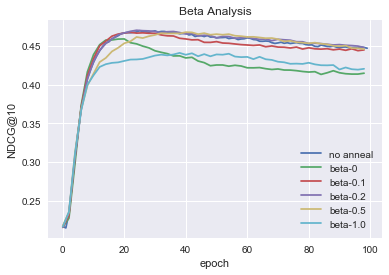

In [42]:
plt.title('Beta Analysis')
beta_range = [-1, 0, 0.1, 0.2, 0.5, 1.0]
for beta in beta_range:
    if beta>=0:
        label = label='beta-'+str(beta)
        x = [i for i in range(0,100,2)]
    else:
        label = 'no anneal'
        x = [i for i in range(0,100,1)]
    print len(x)
    print len(vae_ndcgs[beta])
    plt.plot(x, vae_ndcgs[beta], label=label)

plt.ylabel('NDCG@10')
plt.xlabel('epoch')
plt.legend() # 显示图例